## Starbucks Capstone Challenge
Introduction
This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks.

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer.

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

Example
To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

Cleaning
This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

Final Advice
Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

## Data Sets
The data is contained in three files:

portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
profile.json - demographic data for each customer
transcript.json - records for transactions, offers received, offers viewed, and offers completed
Here is the schema and explanation of each variable in the files:

portfolio.json

id (string) - offer id
offer_type (string) - type of offer ie BOGO, discount, informational
difficulty (int) - minimum required spend to complete an offer
reward (int) - reward given for completing an offer
duration (int) - time for offer to be open, in days
channels (list of strings)
profile.json

age (int) - age of the customer
became_member_on (int) - date when customer created an app account
gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
id (str) - customer id
income (float) - customer's income
transcript.json

event (str) - record description (ie transaction, offer received, offer viewed, etc.)
person (str) - customer id
time (int) - time in hours since start of test. The data begins at time t=0
value - (dict of strings) - either an offer id or transaction amount depending on the record
Note: If you are using the workspace, you will need to go to the terminal and run the command conda update pandas before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.

You can see how to access the terminal and how the install works using the two images below. First you need to access the terminal:

In [1]:
import pandas as pd
import numpy as np
import math
import json
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline



from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor

In [2]:
from plotly import __version__

In [3]:
import cufflinks as cf

In [4]:
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot

In [5]:
init_notebook_mode(connected=True)

In [6]:
cf.go_offline()

In [7]:
port = pd.read_json('portfolio.json', orient='records', lines=True)
port.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [8]:
prof = pd.read_json('profile.json', orient='records', lines=True)
trans = pd.read_json('transcript.json', orient='records', lines=True)

## Exploring  Customer Transaction Dataset

In [9]:
trans.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [10]:
# Printing important statistic about the dataset.
# Dataset consist of 4 cols and 306,534 rows with no missing values

print(trans.shape)
print(trans.info())
print(trans.describe())
print(trans.isnull())

(306534, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB
None
                time
count  306534.000000
mean      366.382940
std       200.326314
min         0.000000
25%       186.000000
50%       408.000000
75%       528.000000
max       714.000000
        person  event  value   time
0        False  False  False  False
1        False  False  False  False
2        False  False  False  False
3        False  False  False  False
4        False  False  False  False
...        ...    ...    ...    ...
306529   False  False  False  False
306530   False  False  False  False
306531   False  False  False  False
306532   False  False  False  False
306533   False  

## Let's review the information below.

As we can see that there was 138,953 made. 76,277 customer recieved the offer, 57,725 view offer and 33,579 completed which is only 12%

Questions.

1.How can we get more customer to complete offer?  



In [11]:
# transaction history showing 138,953 was made. 
#76,277 customer recieved the offer
# 57,725 view the offer and only 33,579 completed the offered. ( )
trans['event'].value_counts()


transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [12]:
# transaction event in percentage
trans['event'].value_counts()/len(trans)*100

transaction        45.330371
offer received     24.883700
offer viewed       18.831516
offer completed    10.954413
Name: event, dtype: float64

In [13]:
trans['time'].value_counts()

408    17030
576    17015
504    16822
336    16302
168    16150
       ...  
318      940
330      938
156      914
162      910
150      894
Name: time, Length: 120, dtype: int64

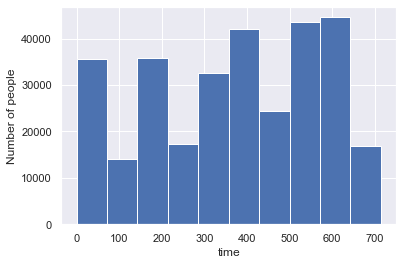

In [14]:
plt.hist(trans['time'],bins=10)
plt.ylabel('Number of people');
plt.xlabel('time');
plt.show()

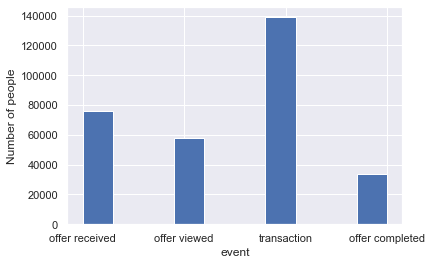

In [15]:
plt.hist(trans['event'],bins=10)
plt.ylabel('Number of people');
plt.xlabel('event');
plt.show()

## Review Portfolio Dataset

In [16]:
port.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [17]:
# Printing important statistic about the dataset.
# Dataset consist of 7 cols and 10 rows with no missing values
# split channels into 4 cols
# no missing values
print(port.shape)
print(port.info())
print(port.describe())
print(port.isnull())

(10, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes
None
          reward  difficulty   duration
count  10.000000   10.000000  10.000000
mean    4.200000    7.700000   6.500000
std     3.583915    5.831905   2.321398
min     0.000000    0.000000   3.000000
25%     2.000000    5.000000   5.000000
50%     4.000000    8.500000   7.000000
75%     5.000000   10.000000   7.000000
max    10.000000   20.000000  10.000000
   reward  channels  difficulty  duration  offer_type     id
0   False     False       False     False       False  False
1   False     False       Fal

In [18]:
port['channels']

0         [email, mobile, social]
1    [web, email, mobile, social]
2            [web, email, mobile]
3            [web, email, mobile]
4                    [web, email]
5    [web, email, mobile, social]
6    [web, email, mobile, social]
7         [email, mobile, social]
8    [web, email, mobile, social]
9            [web, email, mobile]
Name: channels, dtype: object

In [19]:
# Splitting channels into 4 new columns

port['channel_web'] =  port['channels'].apply(lambda x: 1 if 'web' in x else 0)

port['channel_email'] = port['channels'].apply(lambda x: 2 if 'email' in x else 0)


port['channel_social'] = port['channels'].apply(lambda x: 3 if 'social' in x else 0)

port['channel_mobile'] = port['channels'].apply(lambda x: 4 if 'mobile' in x else 0)

port[['channels','channel_email','channel_mobile','channel_web','channel_social']]


,channels,channel_email,channel_mobile,channel_web,channel_social
0,"[email, mobile, social]",2,4,0,3
1,"[web, email, mobile, social]",2,4,1,3
2,"[web, email, mobile]",2,4,1,0
3,"[web, email, mobile]",2,4,1,0
4,"[web, email]",2,0,1,0
5,"[web, email, mobile, social]",2,4,1,3
6,"[web, email, mobile, social]",2,4,1,3
7,"[email, mobile, social]",2,4,0,3
8,"[web, email, mobile, social]",2,4,1,3
9,"[web, email, mobile]",2,4,1,0


In [20]:
# drop channels column
port.drop('channels', axis=1, inplace=True)
port.head()

,reward,difficulty,duration,offer_type,id,channel_web,channel_email,channel_social,channel_mobile
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,2,3,4
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,2,3,4
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,2,0,4
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,2,0,4
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,2,0,0


In [21]:
# Let's review offer_type
port['offer_type'].value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

## It seems like bogo take less time for customer to open and view offer.

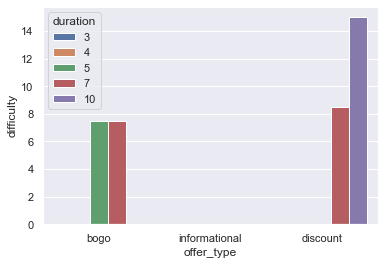

In [22]:
# customer takes about 7 days to complete the bogo offer and over 8  days for the discount
# difficulty min requirement to complete offer
#duration time takes customer to open offer


ax = sns.barplot(x ='offer_type', y ='difficulty', data = port, ci = None, hue ='duration')

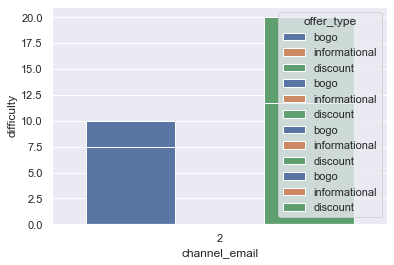

In [23]:
ax = sns.barplot(x ='channel_web', y ='difficulty', data = port, ci = None, hue ='offer_type')
ax = sns.barplot(x ='channel_social', y ='difficulty', data = port, ci = None, hue ='offer_type')
ax = sns.barplot(x ='channel_mobile', y ='difficulty', data = port, ci = None, hue ='offer_type')
ax = sns.barplot(x ='channel_email', y ='difficulty', data = port, ci = None, hue ='offer_type')

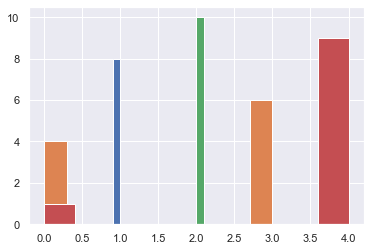

In [24]:
# Mobile and social look like the most active medium.
#email and web take longer time- most customer rarely check their email unless it an emergency

plt.hist(port['channel_web'],bins=10)#Blue
plt.hist(port['channel_social'],bins=10)#orange
plt.hist(port['channel_email'],bins=10)#green
plt.hist(port['channel_mobile'],bins=10)#Red

plt.show()

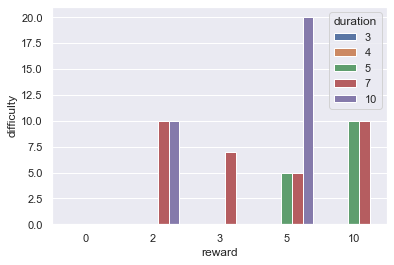

In [25]:
# reward  are given to complete the offer
# duration time take to complete the offer
#difficulty time it take customer to open offer

ax = sns.barplot(x ='reward', y ='difficulty', data = port, ci = None, hue ='duration')

In [26]:
print(port['reward'].describe())
print(port['duration'].describe())

print(port['difficulty'].describe())

count    10.000000
mean      4.200000
std       3.583915
min       0.000000
25%       2.000000
50%       4.000000
75%       5.000000
max      10.000000
Name: reward, dtype: float64
count    10.000000
mean      6.500000
std       2.321398
min       3.000000
25%       5.000000
50%       7.000000
75%       7.000000
max      10.000000
Name: duration, dtype: float64
count    10.000000
mean      7.700000
std       5.831905
min       0.000000
25%       5.000000
50%       8.500000
75%      10.000000
max      20.000000
Name: difficulty, dtype: float64


## Exploring customer profile dataset

In [27]:
prof = pd.read_json('https://raw.githubusercontent.com/tri-bui/starbucks-segmentation/master/data/raw/profile.json',orient='records', lines=True)
prof.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [28]:

prof['age'] = prof['age'].apply(lambda x: np.nan if x == 118 else x)

prof[prof['age'] == 118]

,gender,age,id,became_member_on,income


In [29]:
prof.dropna(inplace=True)
prof.isna().sum()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

In [30]:
prof.head()

,gender,age,id,became_member_on,income
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
5,M,68.0,e2127556f4f64592b11af22de27a7932,20180426,70000.0
8,M,65.0,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
12,M,58.0,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0


In [31]:
# dataset consist of 5 cols and 17,000 rows
# missing gender and income inforamtion 2175

print(prof.shape)
print(prof.info())
print(prof.describe())
print(prof.isnull())

(14825, 5)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               14825 non-null  float64
 2   id                14825 non-null  object 
 3   became_member_on  14825 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 694.9+ KB
None
                age  became_member_on         income
count  14825.000000      1.482500e+04   14825.000000
mean      54.393524      2.016689e+07   65404.991568
std       17.383705      1.188565e+04   21598.299410
min       18.000000      2.013073e+07   30000.000000
25%       42.000000      2.016052e+07   49000.000000
50%       55.000000      2.017080e+07   64000.000000
75%       66.000000      2.017123e+07   80000.000000
max      101.000000      2.018073e+07  120000.000000
      

In [32]:
print(prof['gender'].value_counts)
print(prof['income'].describe())
print(prof['age'].describe())

<bound method IndexOpsMixin.value_counts of 1        F
3        F
5        M
8        M
12       M
        ..
16995    F
16996    M
16997    M
16998    F
16999    F
Name: gender, Length: 14825, dtype: object>
count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64
count    14825.000000
mean        54.393524
std         17.383705
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64


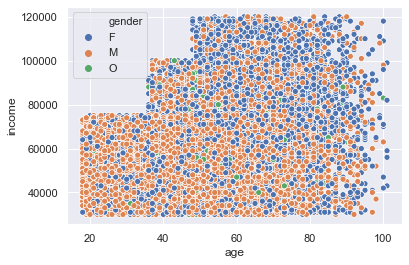

In [33]:
ax = sns.scatterplot(x ='age', y ='income', data = prof, ci=None,hue ='gender')

plt.show()


## Merging Dataframes and performing EDA

1. Merge all three dataframe
2. fillin Nan value with zero
3. irrelevant columns
4. Visualizing data for insightful information

In [34]:
# merge dataframe

df = pd.merge(prof, trans, how = 'left', left_on = ['id'], right_on = ['person'])
df.head()


,gender,age,id,became_member_on,income,person,event,value,time
0,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,0610b486422d4921ae7d2bf64640c50b,transaction,{'amount': 21.51},18
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,0610b486422d4921ae7d2bf64640c50b,transaction,{'amount': 32.28},144
2,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,0610b486422d4921ae7d2bf64640c50b,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},408
3,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,0610b486422d4921ae7d2bf64640c50b,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},504
4,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,0610b486422d4921ae7d2bf64640c50b,transaction,{'amount': 23.22},528


In [35]:
df.drop('person',axis=1)

,gender,age,id,became_member_on,income,event,value,time
0,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 21.51},18
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 32.28},144
2,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},408
3,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},504
4,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 23.22},528
...,...,...,...,...,...,...,...,...
272757,F,62.0,e4052622e5ba45a8b96b59aba68cf068,20170722,82000.0,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,480
272758,F,62.0,e4052622e5ba45a8b96b59aba68cf068,20170722,82000.0,transaction,{'amount': 19.47},486
272759,F,62.0,e4052622e5ba45a8b96b59aba68cf068,20170722,82000.0,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},546
272760,F,62.0,e4052622e5ba45a8b96b59aba68cf068,20170722,82000.0,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},576


In [36]:
df.shape

(272762, 9)

In [37]:
df1 = pd.merge(df, port, how = 'outer', left_on = ['id'], right_on = ['id'])
df1.head(10)

,gender,age,id,became_member_on,income,person,event,value,time,reward,difficulty,duration,offer_type,channel_web,channel_email,channel_social,channel_mobile
0,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715.0,112000.0,0610b486422d4921ae7d2bf64640c50b,transaction,{'amount': 21.51},18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715.0,112000.0,0610b486422d4921ae7d2bf64640c50b,transaction,{'amount': 32.28},144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715.0,112000.0,0610b486422d4921ae7d2bf64640c50b,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},408.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715.0,112000.0,0610b486422d4921ae7d2bf64640c50b,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},504.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715.0,112000.0,0610b486422d4921ae7d2bf64640c50b,transaction,{'amount': 23.22},528.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715.0,112000.0,0610b486422d4921ae7d2bf64640c50b,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,528.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,20170509.0,100000.0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,20170509.0,100000.0,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,20170509.0,100000.0,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,20170509.0,100000.0,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
df1.shape

(272772, 17)

In [39]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272772 entries, 0 to 272771
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   gender            272762 non-null  object 
 1   age               272762 non-null  float64
 2   id                272772 non-null  object 
 3   became_member_on  272762 non-null  float64
 4   income            272762 non-null  float64
 5   person            272762 non-null  object 
 6   event             272762 non-null  object 
 7   value             272762 non-null  object 
 8   time              272762 non-null  float64
 9   reward            10 non-null      float64
 10  difficulty        10 non-null      float64
 11  duration          10 non-null      float64
 12  offer_type        10 non-null      object 
 13  channel_web       10 non-null      float64
 14  channel_email     10 non-null      float64
 15  channel_social    10 non-null      float64
 16  channel_mobile    10

In [40]:
df1.columns

Index(['gender', 'age', 'id', 'became_member_on', 'income', 'person', 'event',
       'value', 'time', 'reward', 'difficulty', 'duration', 'offer_type',
       'channel_web', 'channel_email', 'channel_social', 'channel_mobile'],
      dtype='object')

In [41]:
# some inforamtion still missing - we still keep it.
df1.isnull().sum()

gender                  10
age                     10
id                       0
became_member_on        10
income                  10
person                  10
event                   10
value                   10
time                    10
reward              272762
difficulty          272762
duration            272762
offer_type          272762
channel_web         272762
channel_email       272762
channel_social      272762
channel_mobile      272762
dtype: int64

In [42]:
df1['age'].mean()

53.840696284673086

In [43]:
df1['age'].describe()

count    272762.000000
mean         53.840696
std          17.551337
min          18.000000
25%          41.000000
50%          55.000000
75%          66.000000
max         101.000000
Name: age, dtype: float64

In [44]:

filt_outliers = df1[(df1['age']<98)]
filt_outliers.head()

,gender,age,id,became_member_on,income,person,event,value,time,reward,difficulty,duration,offer_type,channel_web,channel_email,channel_social,channel_mobile
0,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715.0,112000.0,0610b486422d4921ae7d2bf64640c50b,transaction,{'amount': 21.51},18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715.0,112000.0,0610b486422d4921ae7d2bf64640c50b,transaction,{'amount': 32.28},144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715.0,112000.0,0610b486422d4921ae7d2bf64640c50b,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},408.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715.0,112000.0,0610b486422d4921ae7d2bf64640c50b,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},504.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715.0,112000.0,0610b486422d4921ae7d2bf64640c50b,transaction,{'amount': 23.22},528.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
filt_outliers.shape

(272246, 17)

In [46]:
df1.head()

,gender,age,id,became_member_on,income,person,event,value,time,reward,difficulty,duration,offer_type,channel_web,channel_email,channel_social,channel_mobile
0,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715.0,112000.0,0610b486422d4921ae7d2bf64640c50b,transaction,{'amount': 21.51},18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715.0,112000.0,0610b486422d4921ae7d2bf64640c50b,transaction,{'amount': 32.28},144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715.0,112000.0,0610b486422d4921ae7d2bf64640c50b,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},408.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715.0,112000.0,0610b486422d4921ae7d2bf64640c50b,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},504.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715.0,112000.0,0610b486422d4921ae7d2bf64640c50b,transaction,{'amount': 23.22},528.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
new_df = df1['income'].fillna(value=df1['income'].mean())
new_df.head()

0    112000.0
1    112000.0
2    112000.0
3    112000.0
4    112000.0
Name: income, dtype: float64

In [48]:
df1.head()

,gender,age,id,became_member_on,income,person,event,value,time,reward,difficulty,duration,offer_type,channel_web,channel_email,channel_social,channel_mobile
0,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715.0,112000.0,0610b486422d4921ae7d2bf64640c50b,transaction,{'amount': 21.51},18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715.0,112000.0,0610b486422d4921ae7d2bf64640c50b,transaction,{'amount': 32.28},144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715.0,112000.0,0610b486422d4921ae7d2bf64640c50b,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},408.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715.0,112000.0,0610b486422d4921ae7d2bf64640c50b,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},504.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715.0,112000.0,0610b486422d4921ae7d2bf64640c50b,transaction,{'amount': 23.22},528.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
new_df =df1.fillna({
        'event': 'no event',
        'offer_type':'no offer',
        'gender':'na',
        'income':0,
        'age':0,
        'become_member_on':'no date',
        'person':0,
})

new_df


,gender,age,id,became_member_on,income,person,event,value,time,reward,difficulty,duration,offer_type,channel_web,channel_email,channel_social,channel_mobile
0,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715.0,112000.0,0610b486422d4921ae7d2bf64640c50b,transaction,{'amount': 21.51},18.0,NaN,NaN,NaN,no offer,NaN,NaN,NaN,NaN
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715.0,112000.0,0610b486422d4921ae7d2bf64640c50b,transaction,{'amount': 32.28},144.0,NaN,NaN,NaN,no offer,NaN,NaN,NaN,NaN
2,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715.0,112000.0,0610b486422d4921ae7d2bf64640c50b,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},408.0,NaN,NaN,NaN,no offer,NaN,NaN,NaN,NaN
3,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715.0,112000.0,0610b486422d4921ae7d2bf64640c50b,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},504.0,NaN,NaN,NaN,no offer,NaN,NaN,NaN,NaN
4,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715.0,112000.0,0610b486422d4921ae7d2bf64640c50b,transaction,{'amount': 23.22},528.0,NaN,NaN,NaN,no offer,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272767,na,0.0,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,0.0,0,no event,NaN,NaN,3.0,7.0,7.0,discount,1.0,2.0,3.0,4.0
272768,na,0.0,fafdcd668e3743c1bb461111dcafc2a4,NaN,0.0,0,no event,NaN,NaN,2.0,10.0,10.0,discount,1.0,2.0,3.0,4.0
272769,na,0.0,5a8bc65990b245e5a138643cd4eb9837,NaN,0.0,0,no event,NaN,NaN,0.0,0.0,3.0,informational,0.0,2.0,3.0,4.0
272770,na,0.0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,0.0,0,no event,NaN,NaN,5.0,5.0,5.0,bogo,1.0,2.0,3.0,4.0


In [50]:
new_df.head()
print(new_df.shape)

(272772, 17)


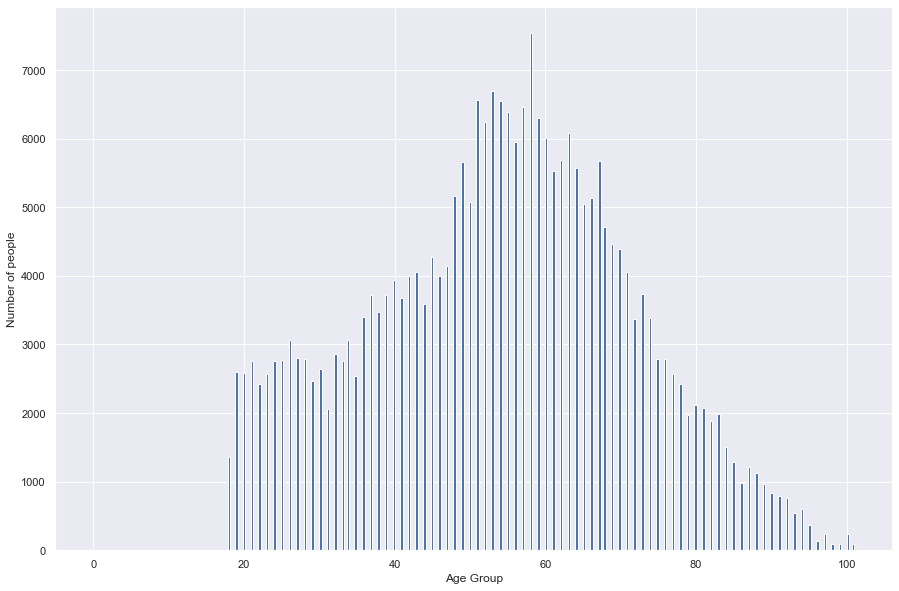

In [91]:
plt.hist(df1['age'],bins=300)
plt.ylabel('Number of people');
plt.xlabel('Age Group');
plt.show()

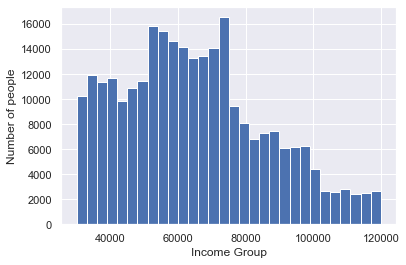

In [52]:
plt.hist(df1['income'],bins=30)
plt.ylabel('Number of people');
plt.xlabel('Income Group');
plt.show()

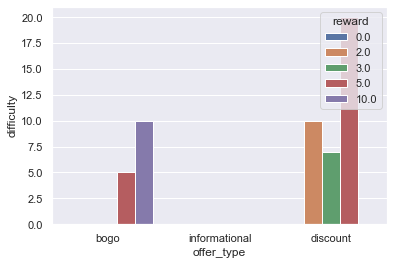

In [53]:
ax = sns.barplot(x ='offer_type', y ='difficulty', data = df1, ci=None,hue ='reward')

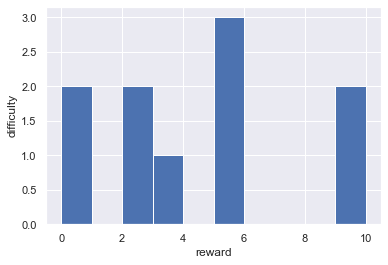

In [54]:
# reward given for completing an offer
# mini requirement spend to complete an offer

plt.hist(df1['reward'],bins=10)
plt.ylabel('difficulty');
plt.xlabel('reward');
plt.show()

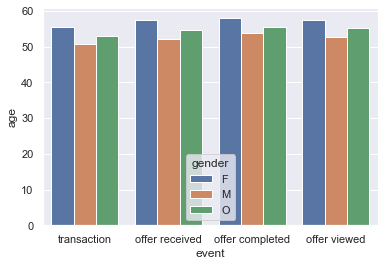

In [55]:
ax = sns.barplot(x ='event', y ='age', data = df1, ci=None,hue ='gender')

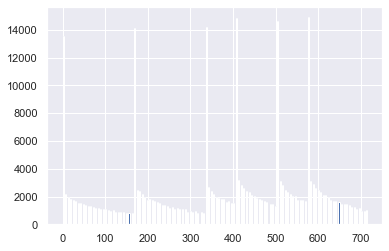

In [56]:
plt.hist(df1['time'],bins=300)

plt.show()

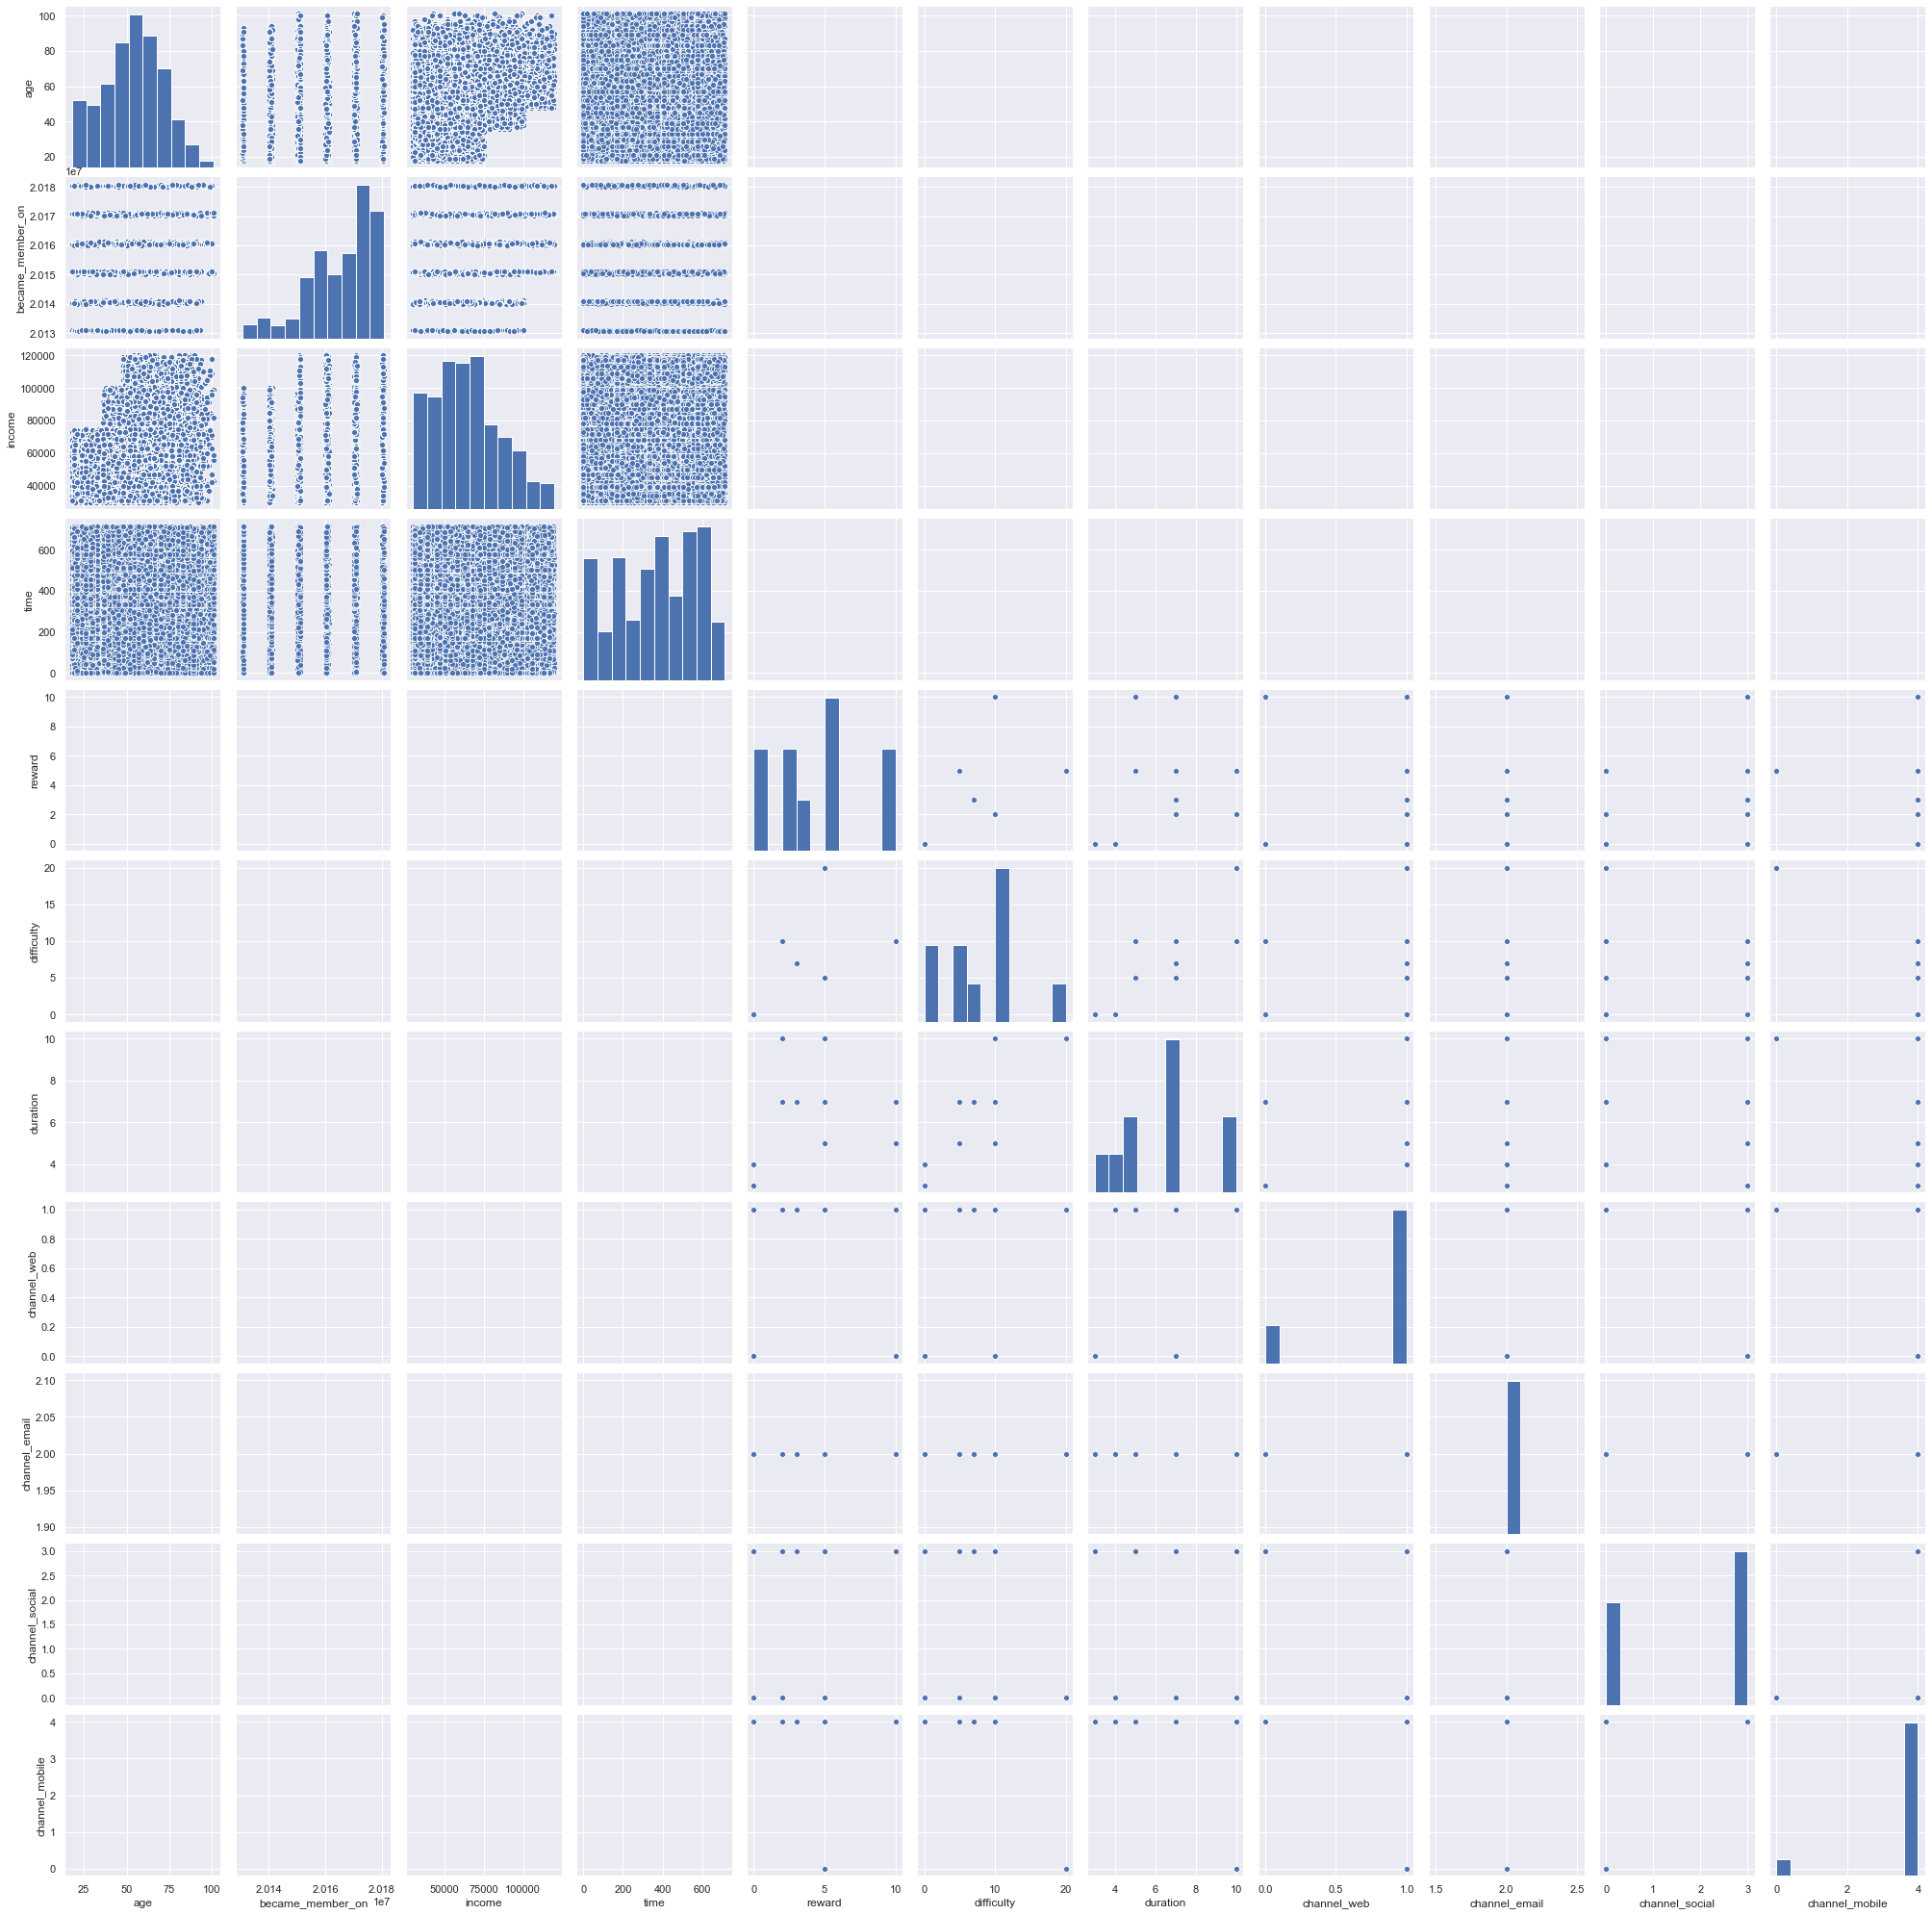

In [57]:
sns.pairplot(df1)
sns.set(rc={'figure.figsize':(15,10)})

In [58]:
df1['event'].value_counts()

transaction        123957
offer received      66501
offer viewed        49860
offer completed     32444
Name: event, dtype: int64

In [59]:
df2 = df1

In [60]:
df1.drop(['person'], axis=1,inplace=True)

In [61]:
df1["became_member_on"] = pd.to_datetime(df1["became_member_on"])

In [62]:
df1.head()

,gender,age,id,became_member_on,income,event,value,time,reward,difficulty,duration,offer_type,channel_web,channel_email,channel_social,channel_mobile
0,F,55.0,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,112000.0,transaction,{'amount': 21.51},18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,112000.0,transaction,{'amount': 32.28},144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,F,55.0,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,112000.0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},408.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,F,55.0,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,112000.0,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},504.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,F,55.0,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,112000.0,transaction,{'amount': 23.22},528.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
df1['became_member_on'].value_counts().head()

1970-01-01 00:00:00.020171207    635
1970-01-01 00:00:00.020171212    631
1970-01-01 00:00:00.020171007    628
1970-01-01 00:00:00.020170819    605
1970-01-01 00:00:00.020180125    597
Name: became_member_on, dtype: int64

In [64]:
df1.event.value_counts()/len(df1)*100

transaction        45.443447
offer received     24.379702
offer viewed       18.279002
offer completed    11.894183
Name: event, dtype: float64

In [65]:
df1['age'].describe()

count    272762.000000
mean         53.840696
std          17.551337
min          18.000000
25%          41.000000
50%          55.000000
75%          66.000000
max         101.000000
Name: age, dtype: float64

In [66]:
df1.gender.value_counts()/len(df1)*100


M    57.076973
F    41.463567
O     1.455795
Name: gender, dtype: float64

In [67]:
df1.isnull().sum()

gender                  10
age                     10
id                       0
became_member_on        10
income                  10
event                   10
value                   10
time                    10
reward              272762
difficulty          272762
duration            272762
offer_type          272762
channel_web         272762
channel_email       272762
channel_social      272762
channel_mobile      272762
dtype: int64

In [68]:
df1[['gender', "age", "income"]][df1['age']==101].head(10)

,gender,age,income
24569,F,101.0,43000.0
24570,F,101.0,43000.0
24571,F,101.0,43000.0
24572,F,101.0,43000.0
24573,F,101.0,43000.0
24574,F,101.0,43000.0
24575,F,101.0,43000.0
24576,F,101.0,43000.0
24577,F,101.0,43000.0
24578,F,101.0,43000.0


In [69]:
df1[df1['age']==101].count()

gender              98
age                 98
id                  98
became_member_on    98
income              98
event               98
value               98
time                98
reward               0
difficulty           0
duration             0
offer_type           0
channel_web          0
channel_email        0
channel_social       0
channel_mobile       0
dtype: int64

In [70]:
df1 = df1.reindex(columns=['id','became_member_on','gender', 'age', 'income','event','value','time','reward','difficulty','offer_type','channel_web','channel_email','channel_social','channel_mobile'])
df1.head()

,id,became_member_on,gender,age,income,event,value,time,reward,difficulty,offer_type,channel_web,channel_email,channel_social,channel_mobile
0,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,F,55.0,112000.0,transaction,{'amount': 21.51},18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,F,55.0,112000.0,transaction,{'amount': 32.28},144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,F,55.0,112000.0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},408.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,F,55.0,112000.0,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},504.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,F,55.0,112000.0,transaction,{'amount': 23.22},528.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:

df1.fillna(0, inplace=True)

In [72]:
df1.head()

,id,became_member_on,gender,age,income,event,value,time,reward,difficulty,offer_type,channel_web,channel_email,channel_social,channel_mobile
0,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,F,55.0,112000.0,transaction,{'amount': 21.51},18.0,0.0,0.0,0,0.0,0.0,0.0,0.0
1,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,F,55.0,112000.0,transaction,{'amount': 32.28},144.0,0.0,0.0,0,0.0,0.0,0.0,0.0
2,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,F,55.0,112000.0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},408.0,0.0,0.0,0,0.0,0.0,0.0,0.0
3,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,F,55.0,112000.0,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},504.0,0.0,0.0,0,0.0,0.0,0.0,0.0
4,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,F,55.0,112000.0,transaction,{'amount': 23.22},528.0,0.0,0.0,0,0.0,0.0,0.0,0.0


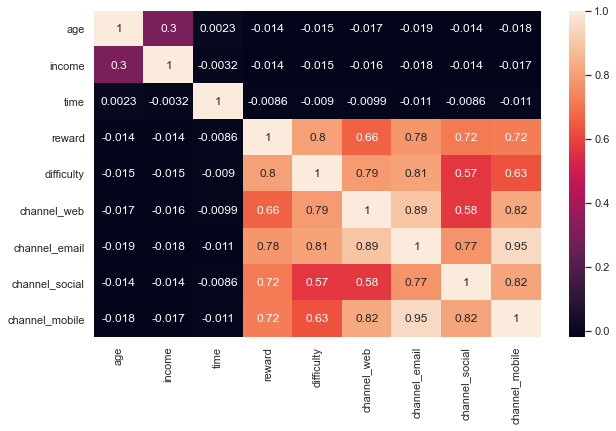

In [157]:
cormat = df1.corr()
plt.figure(figsize=(10,6))
sns.heatmap(cormat,annot=True)

In [73]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272772 entries, 0 to 272771
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                272772 non-null  object 
 1   became_member_on  272772 non-null  object 
 2   gender            272772 non-null  object 
 3   age               272772 non-null  float64
 4   income            272772 non-null  float64
 5   event             272772 non-null  object 
 6   value             272772 non-null  object 
 7   time              272772 non-null  float64
 8   reward            272772 non-null  float64
 9   difficulty        272772 non-null  float64
 10  offer_type        272772 non-null  object 
 11  channel_web       272772 non-null  float64
 12  channel_email     272772 non-null  float64
 13  channel_social    272772 non-null  float64
 14  channel_mobile    272772 non-null  float64
dtypes: float64(9), object(6)
memory usage: 43.3+ MB


In [74]:
dummies = pd.get_dummies(df1.offer_type)
dummies.head()

,0,bogo,discount,informational
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


In [75]:
df2 = pd.concat([df1,dummies],axis='columns')
df2.head()

,id,became_member_on,gender,age,income,event,value,time,reward,difficulty,offer_type,channel_web,channel_email,channel_social,channel_mobile,0,bogo,discount,informational
0,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,F,55.0,112000.0,transaction,{'amount': 21.51},18.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1,0,0,0
1,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,F,55.0,112000.0,transaction,{'amount': 32.28},144.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1,0,0,0
2,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,F,55.0,112000.0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},408.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1,0,0,0
3,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,F,55.0,112000.0,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},504.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1,0,0,0
4,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,F,55.0,112000.0,transaction,{'amount': 23.22},528.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1,0,0,0


In [76]:
dummies = pd.get_dummies(df2.gender)
dummies.head()

,0,F,M,O
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0


In [77]:
df3 = pd.concat([df2,dummies],axis='columns')
df3.head()

,id,became_member_on,gender,age,income,event,value,time,reward,difficulty,...,channel_social,channel_mobile,0,bogo,discount,informational,0,F,M,O
0,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,F,55.0,112000.0,transaction,{'amount': 21.51},18.0,0.0,0.0,...,0.0,0.0,1,0,0,0,0,1,0,0
1,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,F,55.0,112000.0,transaction,{'amount': 32.28},144.0,0.0,0.0,...,0.0,0.0,1,0,0,0,0,1,0,0
2,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,F,55.0,112000.0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},408.0,0.0,0.0,...,0.0,0.0,1,0,0,0,0,1,0,0
3,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,F,55.0,112000.0,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},504.0,0.0,0.0,...,0.0,0.0,1,0,0,0,0,1,0,0
4,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,F,55.0,112000.0,transaction,{'amount': 23.22},528.0,0.0,0.0,...,0.0,0.0,1,0,0,0,0,1,0,0


In [78]:
dummies=pd.get_dummies(df3.event)
dummies.head()


,0,offer completed,offer received,offer viewed,transaction
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,1,0,0
3,0,0,1,0,0
4,0,0,0,0,1


In [79]:
final = pd.concat([df3,dummies],axis='columns')
final.head()

,id,became_member_on,gender,age,income,event,value,time,reward,difficulty,...,informational,0,F,M,O,0,offer completed,offer received,offer viewed,transaction
0,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,F,55.0,112000.0,transaction,{'amount': 21.51},18.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1
1,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,F,55.0,112000.0,transaction,{'amount': 32.28},144.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1
2,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,F,55.0,112000.0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},408.0,0.0,0.0,...,0,0,1,0,0,0,0,1,0,0
3,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,F,55.0,112000.0,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},504.0,0.0,0.0,...,0,0,1,0,0,0,0,1,0,0
4,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,F,55.0,112000.0,transaction,{'amount': 23.22},528.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1


In [80]:
final.drop(columns=['id','became_member_on','gender','value','informational'],axis=1,inplace=True)
final.head()

,age,income,event,time,reward,difficulty,offer_type,channel_web,channel_email,channel_social,...,discount,0,F,M,O,0,offer completed,offer received,offer viewed,transaction
0,55.0,112000.0,transaction,18.0,0.0,0.0,0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1
1,55.0,112000.0,transaction,144.0,0.0,0.0,0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1
2,55.0,112000.0,offer received,408.0,0.0,0.0,0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,1,0,0
3,55.0,112000.0,offer received,504.0,0.0,0.0,0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,1,0,0
4,55.0,112000.0,transaction,528.0,0.0,0.0,0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1


In [81]:
final.head()

,age,income,event,time,reward,difficulty,offer_type,channel_web,channel_email,channel_social,...,discount,0,F,M,O,0,offer completed,offer received,offer viewed,transaction
0,55.0,112000.0,transaction,18.0,0.0,0.0,0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1
1,55.0,112000.0,transaction,144.0,0.0,0.0,0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1
2,55.0,112000.0,offer received,408.0,0.0,0.0,0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,1,0,0
3,55.0,112000.0,offer received,504.0,0.0,0.0,0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,1,0,0
4,55.0,112000.0,transaction,528.0,0.0,0.0,0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1


In [133]:
final.drop(columns=['offer_type'],axis=1,inplace=True)
final.head()

,age,income,reward,difficulty,channel_web,channel_social,channel_mobile,0,bogo,discount,0,F,M,0,offer completed,offer received,offer viewed
0,55.0,112000.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,0,0,0,0,0
1,55.0,112000.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,0,0,0,0,0
2,55.0,112000.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,0,0,0,1,0
3,55.0,112000.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,0,0,0,1,0
4,55.0,112000.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,0,0,0,0,0


In [134]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272772 entries, 0 to 272771
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   age              272772 non-null  float64
 1   income           272772 non-null  float64
 2   reward           272772 non-null  float64
 3   difficulty       272772 non-null  float64
 4   channel_web      272772 non-null  float64
 5   channel_social   272772 non-null  float64
 6   channel_mobile   272772 non-null  float64
 7   0                272772 non-null  uint8  
 8   bogo             272772 non-null  uint8  
 9   discount         272772 non-null  uint8  
 10  0                272772 non-null  uint8  
 11  F                272772 non-null  uint8  
 12  M                272772 non-null  uint8  
 13  0                272772 non-null  uint8  
 14  offer completed  272772 non-null  uint8  
 15  offer received   272772 non-null  uint8  
 16  offer viewed     272772 non-null  uint

In [135]:
X = final.drop('offer completed', axis =1) # input variables
y = final["offer completed"]# output variables

In [136]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1,stratify=y)

In [137]:
from sklearn.linear_model import LogisticRegression

In [138]:
logmodel=LogisticRegression()

In [139]:
logmodel.fit(X_train, y_train)

LogisticRegression()

In [156]:
model.score(X_test,y_test)

0.8810558152323343

In [142]:
from sklearn.metrics import accuracy_score, f1_score

In [143]:
predictions = logmodel.predict(X_test)

In [144]:
from sklearn.metrics import classification_report

In [145]:
from sklearn.metrics import classification_report,confusion_matrix

In [146]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94     48066
           1       0.00      0.00      0.00      6489

    accuracy                           0.88     54555
   macro avg       0.44      0.50      0.47     54555
weighted avg       0.78      0.88      0.83     54555



/Users/Sunita/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [147]:
accuracy_score(y_test,predictions)

0.8810558152323343

In [148]:
from sklearn.metrics import confusion_matrix

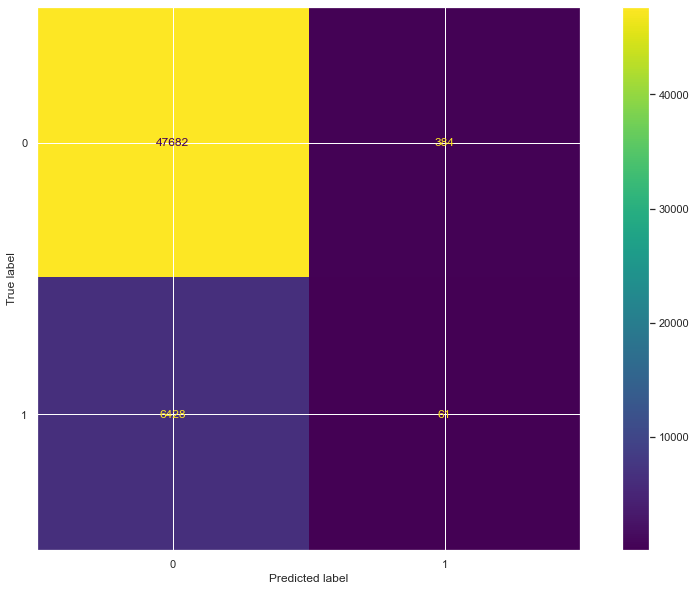

In [155]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(rfc,X_test,y_test)

In [150]:
confusion_matrix(y_test,predictions)

array([[48066,     0],
       [ 6489,     0]])

In [151]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93     48066
           1       0.14      0.01      0.02      6489

    accuracy                           0.88     54555
   macro avg       0.51      0.50      0.48     54555
weighted avg       0.79      0.88      0.82     54555



In [152]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier()
model.fit(X_train, y_train)

GradientBoostingClassifier()

In [153]:
print(classification_report(y_test,model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94     48066
           1       0.00      0.00      0.00      6489

    accuracy                           0.88     54555
   macro avg       0.44      0.50      0.47     54555
weighted avg       0.78      0.88      0.83     54555



/Users/Sunita/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [154]:
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
